## Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)
from sklearn.calibration import calibration_curve, CalibrationDisplay


from imblearn.over_sampling import RandomOverSampler

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from plotnine import *
theme_set(theme_tufte())

## Data

In [3]:
df_wq = pd.read_csv('wine_quality_imbalance.csv')

In [4]:
df_wq.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
quality_89                int64
dtype: object

In [5]:
df_wq = df_wq.drop(columns='quality') # drop the original target column
df_wq['red'] = (df_wq['color'] == 'red').astype(int)
df_wq = df_wq.drop(columns='color')

In [6]:
df_wq.to_csv('wine_quality_imbalance_binary.csv', index=False)

In [7]:
df_wq.corr().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_89,red
fixed acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10,-0.05,0.49
volatile acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04,-0.05,0.65
citric acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.10,-0.33,0.06,-0.01,0.02,-0.19
residual sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36,-0.00,-0.35
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26,-0.08,0.51
free sulfur dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18,0.04,-0.47
total sulfur dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.27,0.01,-0.70
density,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69,-0.13,0.39
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12,0.01,0.33
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.26,0.19,1.00,-0.00,-0.02,0.49


In [8]:
X = df_wq.drop(columns='quality_89')
y = df_wq['quality_89']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [9]:

# Combine training and test indices into one dataframe
df_indices = pd.DataFrame({
    'Index': np.concatenate([X_train.index, X_test.index]),
    'Dataset': ['Train'] * len(X_train.index) + ['Test'] * len(X_test.index)
})

# Save the combined dataframe to csv
df_indices.to_csv('train_test_indices.csv', index=False)

In [10]:
np.mean(y)  # roughly 3% of the data is a high rating of 8 or 9

0.030475604124980762

### Oversampled data

In [11]:
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [12]:
X_train.shape, X_train_os.shape

((4872, 12), (9448, 12))

## Model Fitting

Initialize models; ideally you would tune the lgbm hyperparameters, but there wasn't a real performance difference in this case from the following settings, and this makes for a more direct comparison.

In [13]:
models = {
    'Logistic Basic': LogisticRegression(penalty=None, max_iter=10000),
    'Logistic Over': LogisticRegression(penalty=None, max_iter=10000),
    'Logistic Weighted': LogisticRegression(class_weight='balanced', max_iter=10000),
    'LGBM Basic': LGBMClassifier(
        n_estimators=250, learning_rate=0.1, max_depth=5, verbose=-1
    ),
    'LGBM Over': LGBMClassifier(
        n_estimators=250, learning_rate=0.1, max_depth=5, verbose=-1
    ),
    'LGBM Weighted': LGBMClassifier(
        n_estimators=250, learning_rate=0.1, max_depth=5, is_unbalance=True, verbose=-1
    ),
}

# Fit models
models['Logistic Basic'].fit(X_train, y_train)
models['Logistic Over'].fit(X_train_os, y_train_os)
models['Logistic Weighted'].fit(X_train, y_train)
models['LGBM Basic'].fit(X_train, y_train)
models['LGBM Over'].fit(X_train_os, y_train_os)
models['LGBM Weighted'].fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, max_depth=5, n_estimators=250, verbose=-1)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the parameter grid
param_grid = {
    'n_estimators': [250, 500],
    'learning_rate': np.linspace(1e-2, 0.1, 10),
    'max_depth': list(range(2, 10))
}

# Initialize models
mods = {
    'LGBM Basic Tuned': LGBMClassifier(verbose=-1),
    'LGBM Over Tuned': LGBMClassifier(verbose=-1),
    'LGBM Weighted Tuned': LGBMClassifier(is_unbalance=True, verbose=-1)
}
# Perform StratifiedKFold for each model
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in mods.items():
    search = RandomizedSearchCV(
        model, param_grid, n_iter=50, scoring='roc_auc', cv=skf, random_state=42, n_jobs=-1
    )
    if 'Over' in name:
        search.fit(X_train_os, y_train_os)
    else:
        search.fit(X_train, y_train)
    models[name] = search.best_estimator_

# Fit models
models['LGBM Basic Tuned'].fit(X_train, y_train)
models['LGBM Over Tuned'].fit(X_train_os, y_train_os)
models['LGBM Weighted Tuned'].fit(X_train, y_train)
models

{'Logistic Basic': LogisticRegression(max_iter=10000, penalty=None),
 'Logistic Over': LogisticRegression(max_iter=10000, penalty=None),
 'Logistic Weighted': LogisticRegression(class_weight='balanced', max_iter=10000),
 'LGBM Basic': LGBMClassifier(max_depth=5, n_estimators=250, verbose=-1),
 'LGBM Over': LGBMClassifier(max_depth=5, n_estimators=250, verbose=-1),
 'LGBM Weighted': LGBMClassifier(is_unbalance=True, max_depth=5, n_estimators=250, verbose=-1),
 'LGBM Basic Tuned': LGBMClassifier(learning_rate=0.020000000000000004, max_depth=7,
                n_estimators=250, verbose=-1),
 'LGBM Over Tuned': LGBMClassifier(learning_rate=0.08, max_depth=7, n_estimators=500, verbose=-1),
 'LGBM Weighted Tuned': LGBMClassifier(is_unbalance=True, learning_rate=0.020000000000000004,
                max_depth=9, n_estimators=500, verbose=-1)}

In [15]:
# Function to calculate geometric mean threshold
from sklearn.metrics import roc_curve

def geo_mean_threshold(y_true, y_prob, method='roc'):
    if method == 'roc':
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        gmeans = np.sqrt(tpr * (1 - fpr))
    elif method == 'pr':
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        gmeans = np.sqrt(precision * recall)
    else:
        raise ValueError("Method must be 'roc' or 'pr'")
    
    ix = np.argmax(gmeans)
    return thresholds[ix]

def adaptive_calibration_error(y_true, y_prob, n_bins=10):
    quantiles = np.linspace(0, 1, n_bins + 1)
    bin_edges = np.quantile(y_prob, quantiles)
    ece = 0.0
    total_samples = len(y_true)

    for i in range(n_bins):
        bin_mask = (y_prob >= bin_edges[i]) & (y_prob < bin_edges[i + 1])
        bin_size = np.sum(bin_mask)

        if bin_size > 0:
            bin_accuracy = np.mean(y_true[bin_mask])
            bin_confidence = np.mean(y_prob[bin_mask])
            ece += (bin_size / total_samples) * np.abs(bin_confidence - bin_accuracy)

    return ece


In [16]:
# Calculate metrics
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc", "brier_score"]
results = []

for name, model in models.items():
    for dataset, (X, y) in [("Train", (X_train, y_train)), ("Test", (X_test, y_test))]:
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = model.predict(X)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        results.append(
            {
                "Model": name,
                "Dataset": dataset,
                "Threshold": 0.5,
                # 'Accuracy': accuracy_score(y, y_pred),
                "Mean Pred": np.mean(y_prob),
                "Precision": precision_score(y, y_pred),
                "Recall": recall_score(y, y_pred),
                "F1 Score": f1_score(y, y_pred),
                "ROC AUC": roc_auc_score(y, y_prob),
                "Brier Score": brier_score_loss(y, y_prob),
                "ACE": adaptive_calibration_error(y, y_prob),
                "FPR": fp / (fp + tn),
                "FNR": fn / (fn + tp),
                'Total Pos Pred': np.sum(y_pred),
            }
        )

        # Geometric mean threshold
        if "Basic" in name:
            threshold = geo_mean_threshold(y, y_prob, method="pr")
            y_pred_gm = (y_prob >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y, y_pred_gm).ravel()
            results.append(
                {
                    "Model": name + " (T)",
                    "Dataset": dataset,
                    "Threshold": threshold,
                    # 'Accuracy': accuracy_score(y, y_pred_gm),
                    "Mean Pred": np.mean(y_prob),
                    "Precision": precision_score(y, y_pred_gm),
                    "Recall": recall_score(y, y_pred_gm),
                    "F1 Score": f1_score(y, y_pred_gm),
                    "ROC AUC": roc_auc_score(y, y_prob),
                    "Brier Score": brier_score_loss(y, y_prob),
                    "ACE": adaptive_calibration_error(y, y_prob),
                    "FPR": fp / (fp + tn),
                    "FNR": fn / (fn + tp),
                    'Total Pos Pred': np.sum(y_pred_gm),
                }
            )

df_metrics = pd.DataFrame(results)
# df_metrics.query('Dataset == "Test"').sort_values(["Dataset", "Model"]).to_csv(
#     "metrics.csv", index=False
# )

In [17]:
np.mean(y_test).round(3) # reminder

0.031

In [18]:
df_metrics.query('Dataset == "Test"').sort_values(['Dataset', 'Model']).round(3)

,Model,Dataset,Threshold,Mean Pred,Precision,Recall,F1 Score,ROC AUC,Brier Score,ACE,FPR,FNR,Total Pos Pred
10,LGBM Basic,Test,0.500,0.022,0.840,0.42,0.560,0.878,0.019,0.011,0.003,0.58,25
11,LGBM Basic (T),Test,0.718,0.022,1.000,0.40,0.571,0.878,0.019,0.011,0.000,0.60,20
18,LGBM Basic Tuned,Test,0.500,0.028,1.000,0.32,0.485,0.876,0.020,0.008,0.000,0.68,16
19,LGBM Basic Tuned (T),Test,0.397,0.028,0.905,0.38,0.535,0.876,0.020,0.008,0.001,0.62,21
13,LGBM Over,Test,0.500,0.041,0.522,0.48,0.500,0.849,0.026,0.031,0.014,0.52,46
21,LGBM Over Tuned,Test,0.500,0.020,0.759,0.44,0.557,0.850,0.020,0.014,0.004,0.56,29
15,LGBM Weighted,Test,0.500,0.045,0.500,0.50,0.500,0.852,0.027,0.029,0.016,0.50,50
23,LGBM Weighted Tuned,Test,0.500,0.051,0.500,0.46,0.479,0.850,0.027,0.034,0.015,0.54,46
2,Logistic Basic,Test,0.500,0.031,0.000,0.00,0.000,0.752,0.030,0.015,0.001,1.00,1
3,Logistic Basic (T),Test,0.054,0.031,0.098,0.54,0.166,0.752,0.030,0.015,0.157,0.46,275


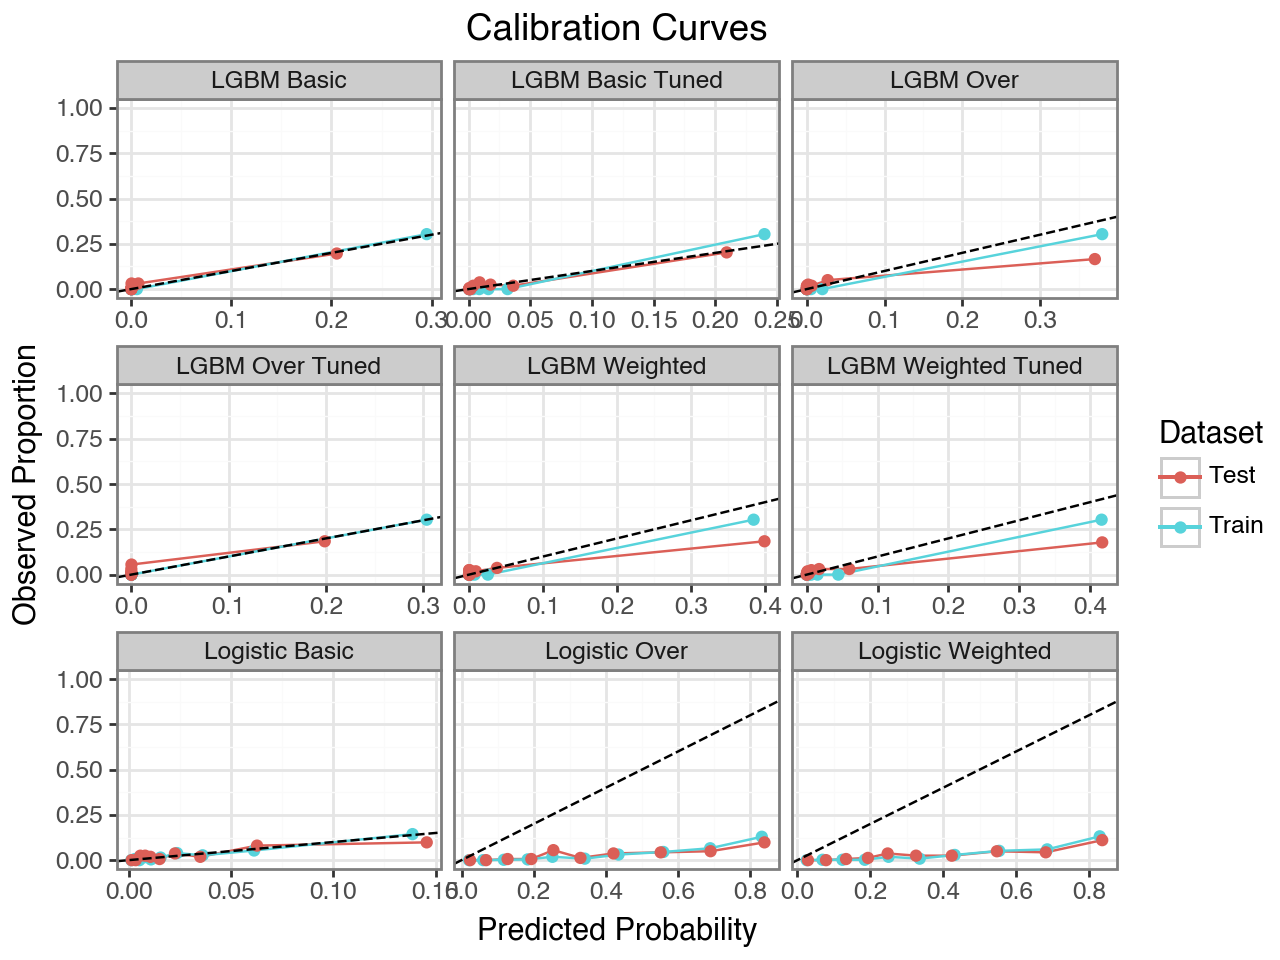

In [41]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# Calibration plots using CalibrationDisplay

# Collect calibration data
calibration_data = []

for name, model in models.items():
    for dataset, (X, y) in [('Train', (X_train, y_train)), ('Test', (X_test, y_test))]:
        prob_true, prob_pred = calibration_curve(y, model.predict_proba(X)[:, 1], n_bins=10, strategy='quantile')
        calibration_data.append(pd.DataFrame({
            'Model': name,
            'Dataset': dataset,
            'Prob True': prob_true,
            'Prob Pred': prob_pred
        }))

df_calibration = pd.concat(calibration_data)
df_calibration.to_csv('calibration_curves.csv', index=False)

# Plot calibration curves using plotnine
(
    ggplot(df_calibration, aes(x='Prob Pred', y='Prob True', color='Dataset'))
    + geom_line()
    + geom_point()
    + geom_abline(linetype='dashed')
    + facet_wrap('~Model', scales='free_x')
    + lims(y=(0, 1))
    + labs(title='Calibration Curves', x='Predicted Probability', y='Observed Proportion')
    + theme_bw()
)


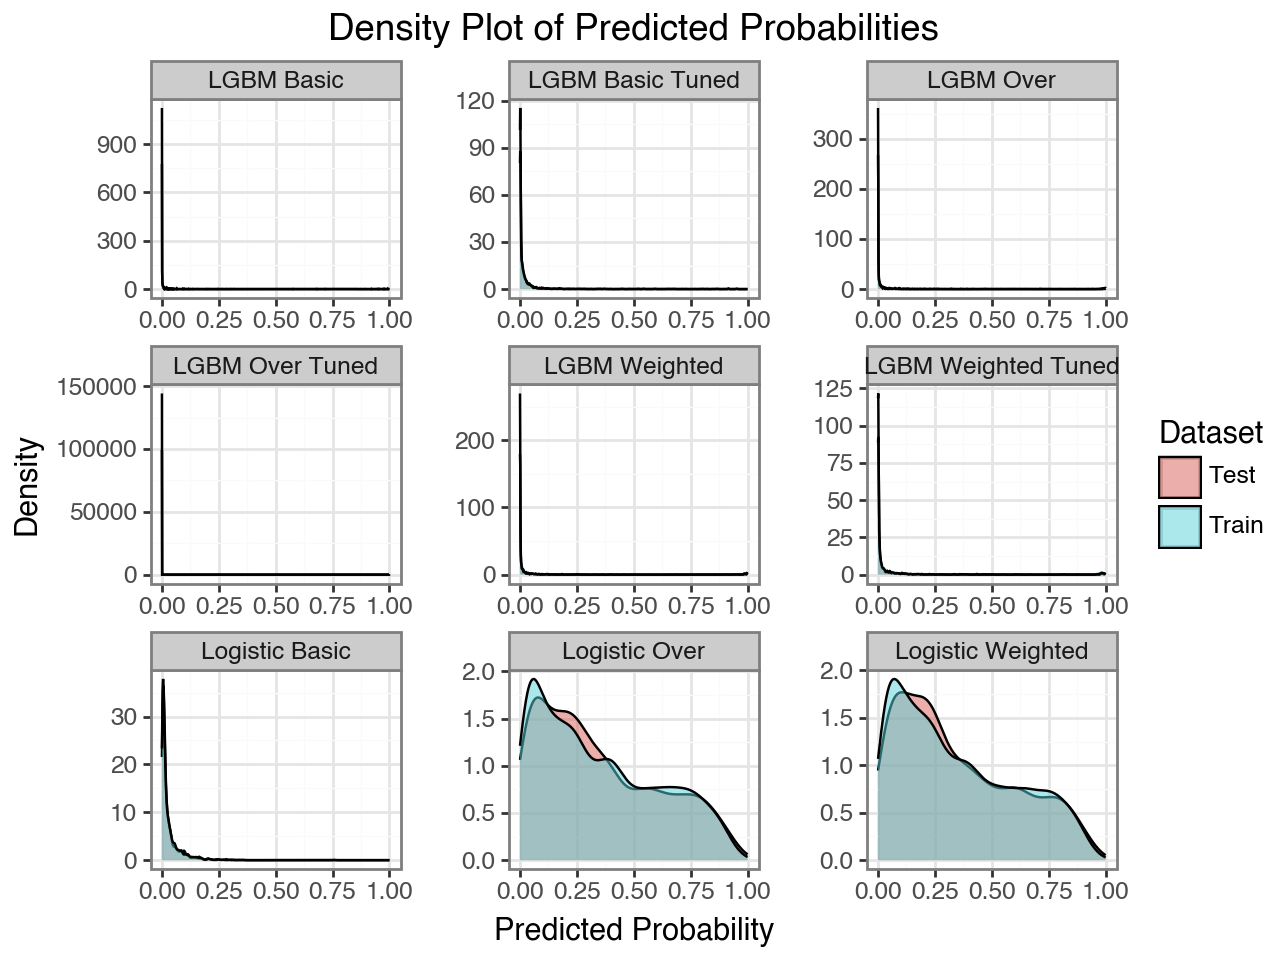

In [42]:
# Density plots
pred_probs = []

for name, model in models.items():
    for dataset, (X, y) in [('Train', (X_train, y_train)), ('Test', (X_test, y_test))]:
        y_prob = model.predict_proba(X)[:, 1]
        pred_probs.append(pd.DataFrame({
            'Model': name,
            'Dataset': dataset,
            'Predicted Probability': y_prob
        }))

df_pred_probs = pd.concat(pred_probs)
df_pred_probs.to_csv('predicted_probabilities.csv', index=False)

(
    ggplot(df_pred_probs, aes(x='Predicted Probability', fill='Dataset'))
    + geom_density(alpha=0.5)
    + facet_wrap('~Model', scales='free')
    + labs(title='Density Plot of Predicted Probabilities', x='Predicted Probability', y='Density')
    + lims(x=(0, 1))   
    + theme_bw()
)



/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_379/3006520098.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


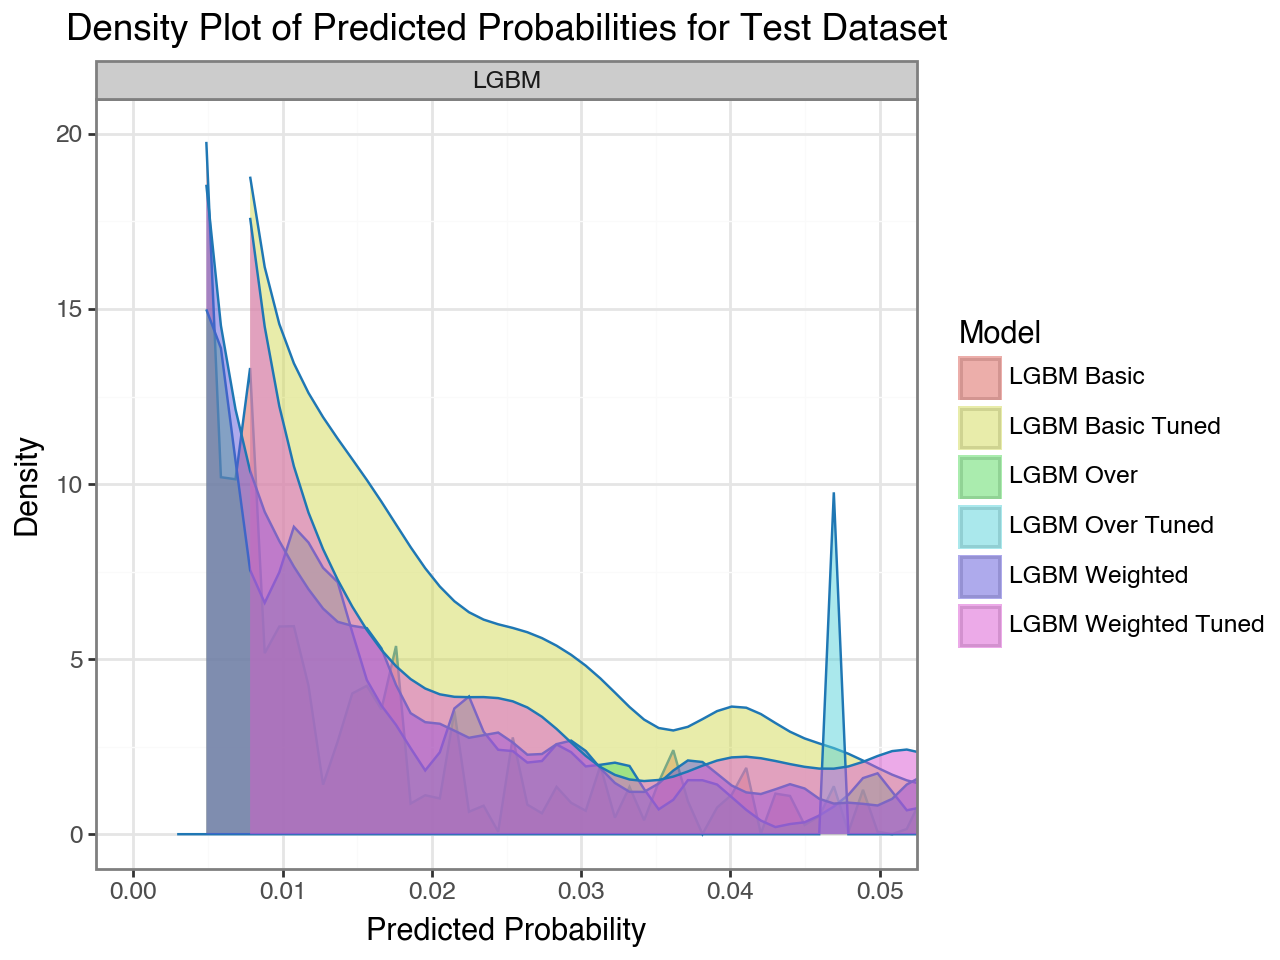

In [43]:
# Filter the predicted probabilities for the required models and datasets
df_filtered_pred_probs = df_pred_probs[
    # ((df_pred_probs['Model'] == 'Logistic Basic') | 
    #  (df_pred_probs['Model'] == 'Logistic Over') | 
    #  (df_pred_probs['Model'] == 'LGBM Basic') | 
    #  (df_pred_probs['Model'] == 'LGBM Over') | 
    #  (df_pred_probs['Model'] == 'LGBM Weighted')) & 
    (df_pred_probs['Dataset'] == 'Test')
]

# Create a new column to distinguish between LGBM and Logistic Regression models
df_filtered_pred_probs['Model_Type'] = df_filtered_pred_probs['Model'].apply(
    lambda x: 'LGBM' if 'LGBM' in x else 'Logistic'
)

(
    ggplot(df_filtered_pred_probs.query('Model_Type == "LGBM"'), aes(x='Predicted Probability', fill='Model'))
    + geom_density(alpha=0.5, color=None)
    + facet_wrap("~Model_Type", scales='free')
    + labs(title='Density Plot of Predicted Probabilities for Test Dataset', x='Predicted Probability', y='Density')
    + lims(x=(0, 1), y=(0, 20))
    + coord_cartesian(xlim=(0, .05))
    + theme_bw()
)

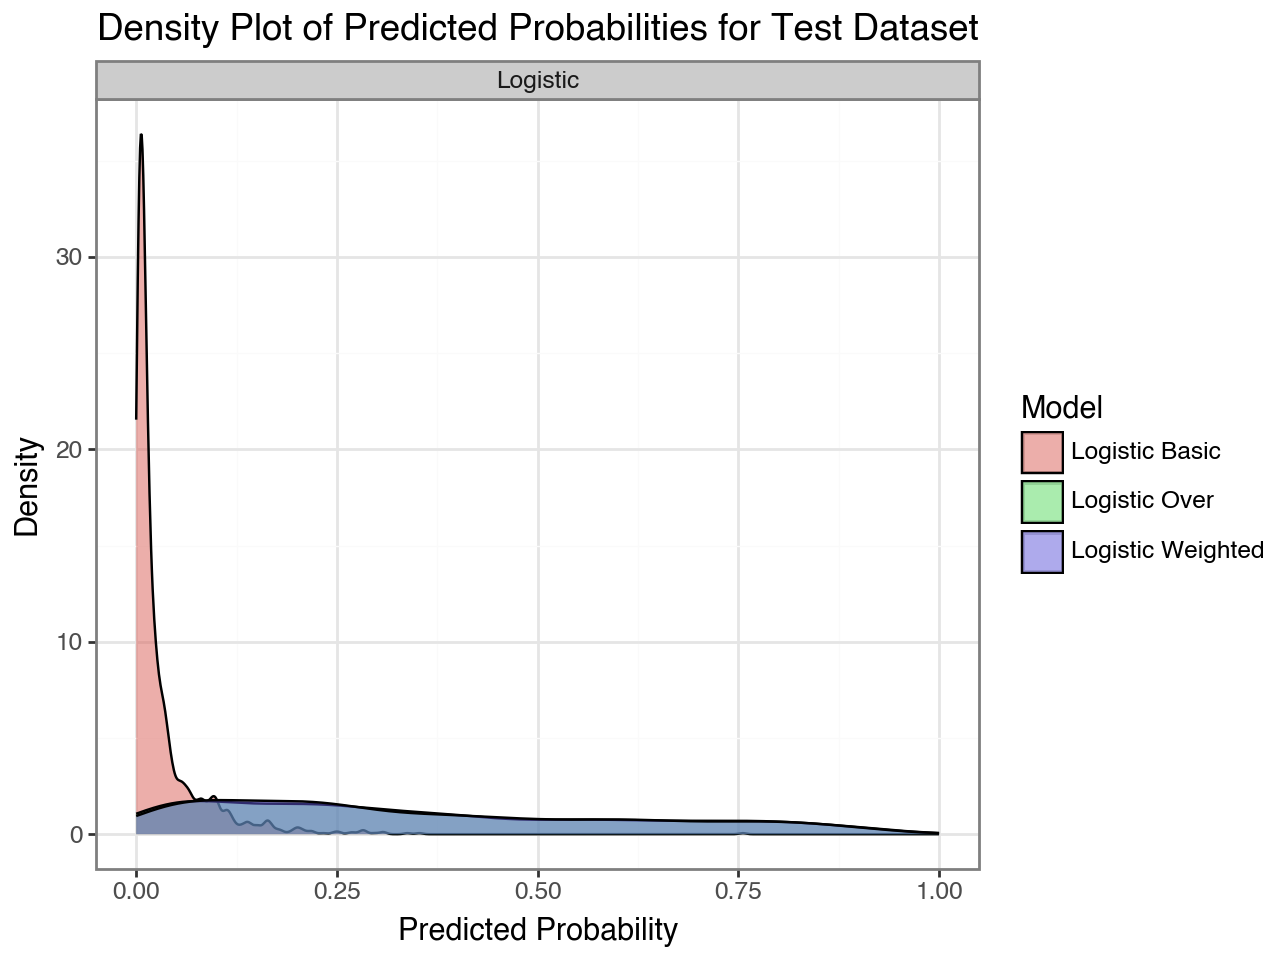

In [44]:
(
    ggplot(df_filtered_pred_probs.query('Model_Type != "LGBM"'), aes(x='Predicted Probability', fill='Model'))
    + geom_density(alpha=0.5)
    + facet_wrap("~Model_Type", scales='free')
    + labs(title='Density Plot of Predicted Probabilities for Test Dataset', x='Predicted Probability', y='Density')
    + lims(x=(0, 1))
    # + coord_cartesian(xlim=(0, .05))
    + theme_bw()
)